## Traditional ML classification models under wavelet analysis structures

In [1]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Implementations
#### Configurations

In [2]:
# Configurations - Feature names
LOWLUX = 'lowlux'
MIDLUX = 'middlelux'
HIGHLUX = 'highlux'
NOBACK = 'nothing'
ONEBACK = 'ONEBACK'
TWOBACK = 'TWOBACK'
THREEBACK = 'THREEBACK'
FILENAME = 'Filename'
IPA2 = 'IPA 2'
INDEX = 'index'
LUX = 'Luminance'
LABELS = 'Labels'
ISBLINK_LEFT = 'isBlink-Left'
ISBLINK_RIGHT = 'isBlink-Right'
PID = 'PID'
AVE_DM = 'Averaged Diameter'
DIFF_DM = 'Difference Diameter'

IPA_LEFT = 'IPA Left'
IPA_RIGHT = 'IPA Right'

LHIPA_LEFT = 'LHIPA Left'
LHIPA_RIGHT = 'LHIPA Right'

# Model names.
KNN = 'KNN'
SVM = 'SVM'
RF = 'Random Forest'

# Training and testing ratio.
TEST_SIZE_PCT = 0.1

# Hyper-parameters tuning.
# Setting thresholds for 2 eyes' blinking rates.
THRES_BLINKING_RATE = 0.3 # The default value.
# The random forest layers.
RF_DEPTH = 10

#### Read data

In [3]:
# Read data and make them into processable formalities.
# filepath = '../Data/Results/21-11-13-13/results.csv' # Without ipa and lhipa features.
filepath = '../Data/Results/22-11-22-23/results.csv' # With ipa and lhipa features.
df_raw_features = pd.read_csv(filepath)

In [4]:
df_raw_features

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,IPA Right,LHIPA Left,LHIPA Right,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,PID,Labels
0,90.878101,90.000122,89.429937,90.488841,90.425234,90.336186,90.534690,90.501258,90.304912,90.299277,...,0.6,7.8,8.6,46.214449,-2.993481,0.325000,0.370000,lowlux,7,nothing
1,90.272990,90.943095,90.475785,90.534682,90.372235,90.283447,90.175733,90.071457,89.966849,89.862239,...,0.6,9.4,8.8,46.102734,-2.943094,0.168333,0.203333,lowlux,7,nothing
2,89.356322,88.406687,88.938648,89.101954,88.632723,89.213376,88.886822,88.681709,89.061931,88.684184,...,0.0,10.2,9.4,46.330987,-3.043528,0.000000,0.000000,lowlux,7,nothing
3,89.591427,90.381350,89.822829,90.178344,90.201855,90.039328,89.327095,90.271126,89.445756,89.488081,...,0.2,9.2,8.8,46.389218,-2.974158,0.135000,0.195000,lowlux,7,nothing
4,89.352206,89.354459,90.085756,90.154200,90.493916,88.939724,89.547730,90.279304,90.332414,91.536459,...,0.4,8.2,9.2,45.993263,-2.558402,0.135000,0.195000,lowlux,7,nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.8,0.0,8.0,46.211527,0.826298,1.000000,0.431667,lowlux,2,THREEBACK
2808,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.6,0.0,7.6,46.219696,0.809960,1.000000,0.530000,lowlux,2,THREEBACK
2809,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,1.0,0.0,6.8,46.202013,0.845325,1.000000,0.663333,lowlux,2,THREEBACK
2810,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.4,0.0,6.0,46.105213,1.038926,1.000000,0.816667,lowlux,2,THREEBACK


#### Encoder

This part encodes features into numeric values.

In [5]:
# Encoding and Labeling
luxes = []
nbacks = []
df_numeric_features = df_raw_features.copy()

for index, row in df_numeric_features.iterrows():
    # Label luxes
    if LOWLUX in row[LUX]:
        luxes.append(30)
    elif MIDLUX in row[LUX]:
        luxes.append(4500)
    elif HIGHLUX in row[LUX]:
        luxes.append(15000)
    
    # Label task difficulties
    if NOBACK in row[LABELS]:
        nbacks.append(0)
    elif ONEBACK in row[LABELS]:
        nbacks.append(1)
    elif TWOBACK in row[LABELS]:
        nbacks.append(2)
    elif THREEBACK in row[LABELS]:
        nbacks.append(3)
        
df_numeric_features[LUX] = luxes
df_numeric_features[LABELS] = nbacks

In [6]:
df_numeric_features

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,IPA Right,LHIPA Left,LHIPA Right,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,PID,Labels
0,90.878101,90.000122,89.429937,90.488841,90.425234,90.336186,90.534690,90.501258,90.304912,90.299277,...,0.6,7.8,8.6,46.214449,-2.993481,0.325000,0.370000,30,7,0
1,90.272990,90.943095,90.475785,90.534682,90.372235,90.283447,90.175733,90.071457,89.966849,89.862239,...,0.6,9.4,8.8,46.102734,-2.943094,0.168333,0.203333,30,7,0
2,89.356322,88.406687,88.938648,89.101954,88.632723,89.213376,88.886822,88.681709,89.061931,88.684184,...,0.0,10.2,9.4,46.330987,-3.043528,0.000000,0.000000,30,7,0
3,89.591427,90.381350,89.822829,90.178344,90.201855,90.039328,89.327095,90.271126,89.445756,89.488081,...,0.2,9.2,8.8,46.389218,-2.974158,0.135000,0.195000,30,7,0
4,89.352206,89.354459,90.085756,90.154200,90.493916,88.939724,89.547730,90.279304,90.332414,91.536459,...,0.4,8.2,9.2,45.993263,-2.558402,0.135000,0.195000,30,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.8,0.0,8.0,46.211527,0.826298,1.000000,0.431667,30,2,3
2808,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.6,0.0,7.6,46.219696,0.809960,1.000000,0.530000,30,2,3
2809,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,1.0,0.0,6.8,46.202013,0.845325,1.000000,0.663333,30,2,3
2810,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.4,0.0,6.0,46.105213,1.038926,1.000000,0.816667,30,2,3


#### Data visualization

In [7]:
# sns.pairplot(df_labels_IPA2, hue=LABELS)

#### Auxiliary functions

In [8]:
# Show machine learning models' performance.
def show_performance(y_true, y_pred, model_name):
    # Get the accuracy score.
    score = accuracy_score(y_true, y_pred)
    
    # Get the confusion matrices and display them.
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    
    ax = plt.figure().subplots()
    ax.set(title=model_name + " MODEL")
    
    cm_display.plot(ax=ax)
    plt.show()
    
    return score

In [9]:
# Plot class distributions with a bar chart.
# Learnt from the quora here.https://stackoverflow.com/questions/63650646/add-labels-and-title-to-a-plot-made-using-pandas.
def plot_class_distribution(df_input, title, x_label, y_label, class_column):
    df = df_input.copy()
#     ax = pd.Series(df[class_column]).value_counts().sort_index().plot(kind='bar')
    ax = pd.Series(df[class_column]).value_counts().sort_index()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.plot(kind='bar')
    plt.show()
    return None

#### Clean the instances and features

In [10]:
# Select validated rows/instances by thresholdings.
def validate_instances(df_input):
    df = df_input.copy()
    
    # Plot the original class distributions.
    plot_class_distribution(df_input=df, title='Original instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # class distributions before.
    
    # Remove instances with high blinking rates.
    before_blinking_filter = len(df)
    df = df.loc[df[ISBLINK_LEFT] <= THRES_BLINKING_RATE]
    df = df.loc[df[ISBLINK_RIGHT] <= THRES_BLINKING_RATE]
    after_blinking_filter = len(df)
    lost_data_num = before_blinking_filter - after_blinking_filter
    print('The blinking threshold is: ' + str(THRES_BLINKING_RATE) + '. Before there was: ' + str(before_blinking_filter) + ' instances, then there is : ' + str(after_blinking_filter) + ' instances. ' + str(lost_data_num) + ' instances are lost.')
    plot_class_distribution(df_input=df, title='Tuned instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # Show the class distributions after tuning.
    
    # Reset the index.
    df = df.reset_index()
    df = df.loc[:, df.columns != 'index']
    
    # Get the output.
    df_output = df.copy()
    return df_output

In [11]:
def select_features(df_input, selected_feature_sets, dropped_feature_sets):
    df = df_input.copy()
    
    # Feature selection
    # Remove PID label / feature.
    df = df.loc[:, df.columns != PID]
    
    # Remove lux
    df = df.loc[:, df.columns != LUX]
    
    # Remove the blinking rates related features.
    df = df.loc[:, df.columns != ISBLINK_LEFT]
    df = df.loc[:, df.columns != ISBLINK_RIGHT]
    
    # Select features according to needs.
    if dropped_feature_sets is False and selected_feature_sets is not False:
        selected_feature_sets.append(LABELS)
        df_output = df[selected_feature_sets]
    elif selected_feature_sets is False and dropped_feature_sets is not False:
        for feature in dropped_feature_sets:
            df = df.loc[:, df.columns != feature]
        df_output = df.copy()
    elif dropped_feature_sets is False and selected_feature_sets is False:
        df_output = df.copy()
    
    return df_output

#### Run the models

In [12]:
# Run the models, get the results.
def ml_pipeline(df_input, label_string):
    df = df_input.copy()
    
    # Split dataset.
    # Get the X and y sets.
    X = df.loc[:, df.columns != LABELS].to_numpy()
    y = df.loc[:, df.columns == LABELS].to_numpy()
    y = np.reshape(y, -1)
    
    # Split the data into training dataset and validation dataset.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PCT, random_state=999)
    
    # Train with models.
    print('------------------------------------------------' + label_string + ' Model ------------------------------------------------')
    # SVM model. TODO: try the SVM model mentioned in 2022 ISMAR and boosting method, and also feature selection method.
    clf_svm = make_pipeline(StandardScaler(),SVC(kernel='poly', degree=7)) #SVC(kernel='rbf', gamma='auto'))
    # Try SVM, bacause it is one of the most widely used models in cognitive workload claissfications.
    clf_svm.fit(X_train, y_train)
    y_pred_svm = clf_svm.predict(X_test)
    score_svm = show_performance(y_true=y_test, y_pred=y_pred_svm, model_name = SVM)
    
    # KNN model.
    clf_knn = KNeighborsClassifier(n_neighbors=5)
    # Train the model.
    clf_knn.fit(X_train, y_train)
    # Test.
    y_pred_knn = clf_knn.predict(X_test)
    score_knn = show_performance(y_true=y_test, y_pred=y_pred_knn, model_name = KNN)
    
    # Random Forest model.
    clf_rf = RandomForestClassifier(max_depth=RF_DEPTH, random_state=0)
    # Train the model.
    clf_rf.fit(X_train, y_train)
    # Test.
    y_pred_rf = clf_rf.predict(X_test)
    score_rf = show_performance(y_true=y_test, y_pred=y_pred_rf, model_name = RF)
    
    # Print the results.
    print('\nThe SVM result is: ' + str(score_svm) +  '\nThe KNN result is: ' + str(score_knn) +  '\nThe RF result is: ' + str(score_rf))
    print('\nThe used features are: ') # Briefly display the features utilized.
    print(df)
    
    # Output the data.
    df_output = df.copy()
    return df_output

#### Machine Learning Implementations

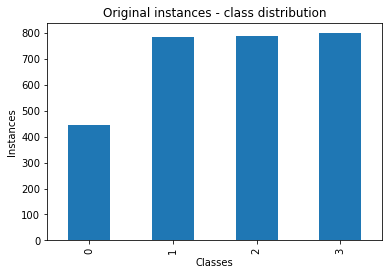

The blinking threshold is: 0.3. Before there was: 2812 instances, then there is : 1300 instances. 1512 instances are lost.


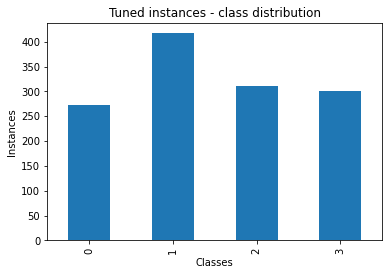

------------------------------------------------Time-domain-based Features Model ------------------------------------------------


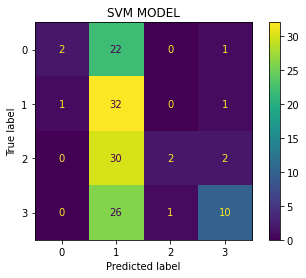

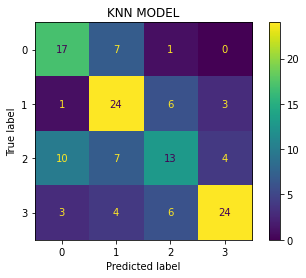

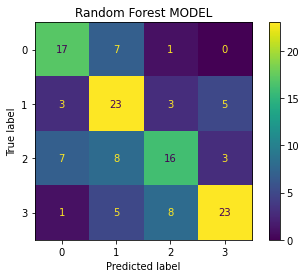


The SVM result is: 0.35384615384615387
The KNN result is: 0.6
The RF result is: 0.6076923076923076

The used features are: 
      Averaged Diameter  Difference Diameter  Labels
0             46.102734            -2.943094       0
1             46.330987            -3.043528       0
2             46.389218            -2.974158       0
3             45.993263            -2.558402       0
4             45.605047            -2.592870       0
...                 ...                  ...     ...
1295          42.890241             0.911319       1
1296          43.455088             1.071264       1
1297          45.114455             2.676425       2
1298          45.265889             2.402693       3
1299          45.107876             2.098402       3

[1300 rows x 3 columns]
------------------------------------------------Freq-domain-based IPA Features Model ------------------------------------------------


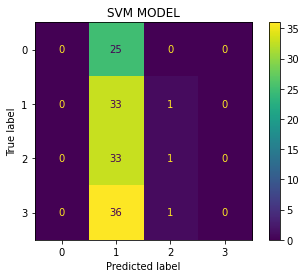

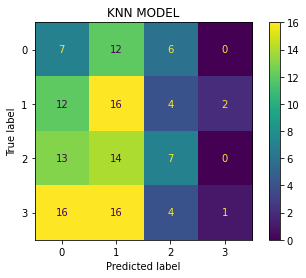

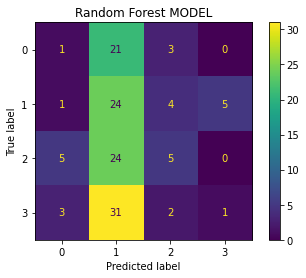


The SVM result is: 0.26153846153846155
The KNN result is: 0.23846153846153847
The RF result is: 0.23846153846153847

The used features are: 
      IPA Left  IPA Right  Labels
0          0.4        0.6       0
1          0.2        0.0       0
2          0.4        0.2       0
3          0.4        0.4       0
4          0.2        0.4       0
...        ...        ...     ...
1295       0.4        0.6       1
1296       0.4        0.6       1
1297       0.6        0.6       2
1298       0.4        0.4       3
1299       0.6        0.4       3

[1300 rows x 3 columns]
------------------------------------------------Freq-domain-based LHIPA Features Model ------------------------------------------------


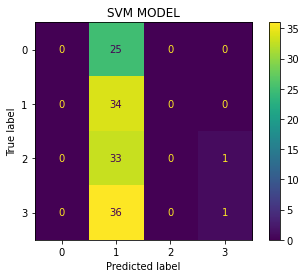

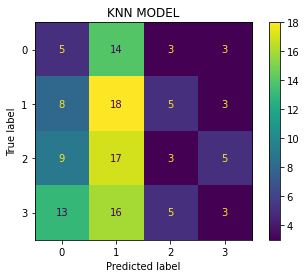

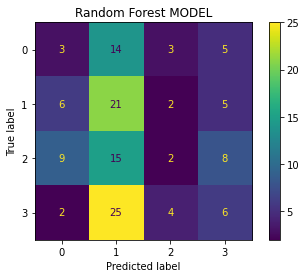


The SVM result is: 0.2692307692307692
The KNN result is: 0.2230769230769231
The RF result is: 0.24615384615384617

The used features are: 
      LHIPA Left  LHIPA Right  Labels
0            9.4          8.8       0
1           10.2          9.4       0
2            9.2          8.8       0
3            8.2          9.2       0
4            8.8          8.8       0
...          ...          ...     ...
1295        10.2         10.4       1
1296         9.0          8.8       1
1297         7.6          9.8       2
1298         8.6          9.6       3
1299         7.8          9.2       3

[1300 rows x 3 columns]
------------------------------------------------Only Wavelet Coefficients Features Model ------------------------------------------------


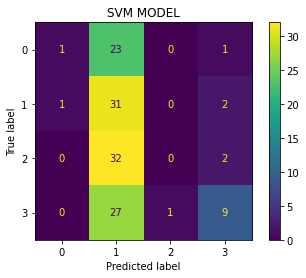

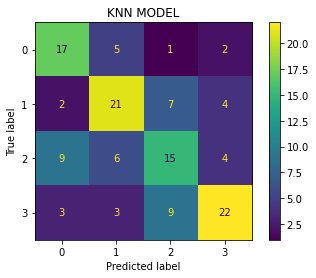

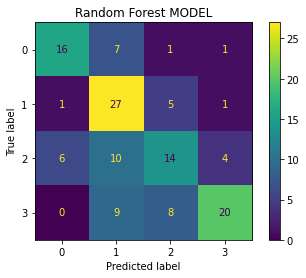


The SVM result is: 0.3153846153846154
The KNN result is: 0.5769230769230769
The RF result is: 0.5923076923076923

The used features are: 
         Left-0     Left-1     Left-2     Left-3     Left-4     Left-5  \
0     90.272990  90.943095  90.475785  90.534682  90.372235  90.283447   
1     89.356322  88.406687  88.938648  89.101954  88.632723  89.213376   
2     89.591427  90.381350  89.822829  90.178344  90.201855  90.039328   
3     89.352206  89.354459  90.085756  90.154200  90.493916  88.939724   
4     90.190303  89.699041  89.647380  89.442384  89.303757  89.144539   
...         ...        ...        ...        ...        ...        ...   
1295  88.243316  87.353155  87.451355  87.116847  87.064689  86.946510   
1296  87.371180  86.022198  86.176763  86.152101  86.307234  86.083863   
1297  91.093841  88.252200  88.838610  88.739409  88.420796  88.599997   
1298  92.739069  93.212414  93.097705  93.173248  93.159971  93.173350   
1299  88.730488  94.100808  92.352796  93.44175

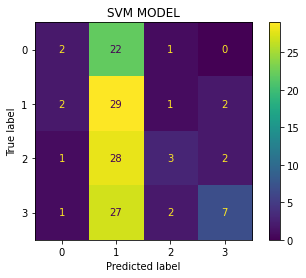

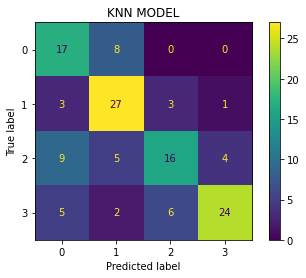

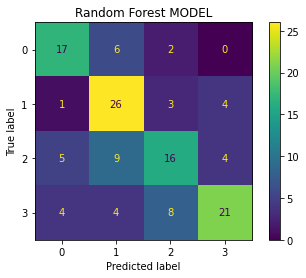


The SVM result is: 0.3153846153846154
The KNN result is: 0.6461538461538462
The RF result is: 0.6153846153846154

The used features are: 
      Averaged Diameter  Difference Diameter  IPA Left  IPA Right  LHIPA Left  \
0             46.102734            -2.943094       0.4        0.6         9.4   
1             46.330987            -3.043528       0.2        0.0        10.2   
2             46.389218            -2.974158       0.4        0.2         9.2   
3             45.993263            -2.558402       0.4        0.4         8.2   
4             45.605047            -2.592870       0.2        0.4         8.8   
...                 ...                  ...       ...        ...         ...   
1295          42.890241             0.911319       0.4        0.6        10.2   
1296          43.455088             1.071264       0.4        0.6         9.0   
1297          45.114455             2.676425       0.6        0.6         7.6   
1298          45.265889             2.402693       

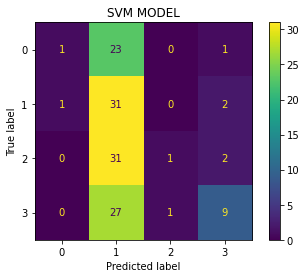

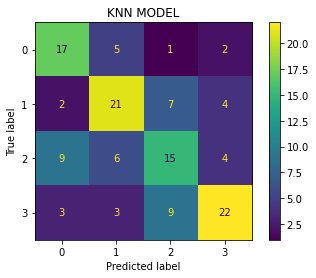

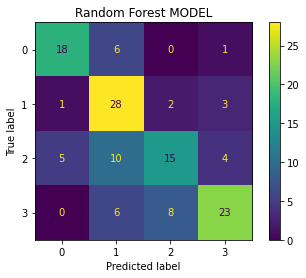


The SVM result is: 0.3230769230769231
The KNN result is: 0.5769230769230769
The RF result is: 0.6461538461538462

The used features are: 
         Left-0     Left-1     Left-2     Left-3     Left-4     Left-5  \
0     90.272990  90.943095  90.475785  90.534682  90.372235  90.283447   
1     89.356322  88.406687  88.938648  89.101954  88.632723  89.213376   
2     89.591427  90.381350  89.822829  90.178344  90.201855  90.039328   
3     89.352206  89.354459  90.085756  90.154200  90.493916  88.939724   
4     90.190303  89.699041  89.647380  89.442384  89.303757  89.144539   
...         ...        ...        ...        ...        ...        ...   
1295  88.243316  87.353155  87.451355  87.116847  87.064689  86.946510   
1296  87.371180  86.022198  86.176763  86.152101  86.307234  86.083863   
1297  91.093841  88.252200  88.838610  88.739409  88.420796  88.599997   
1298  92.739069  93.212414  93.097705  93.173248  93.159971  93.173350   
1299  88.730488  94.100808  92.352796  93.44175

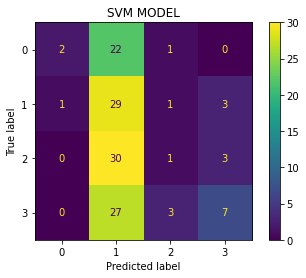

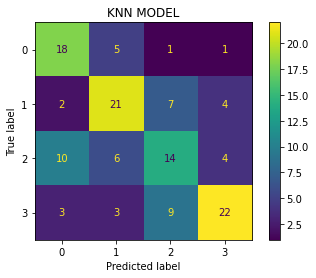

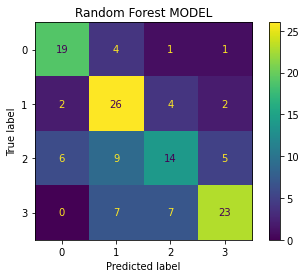


The SVM result is: 0.3
The KNN result is: 0.5769230769230769
The RF result is: 0.6307692307692307

The used features are: 
         Left-0     Left-1     Left-2     Left-3     Left-4     Left-5  \
0     90.272990  90.943095  90.475785  90.534682  90.372235  90.283447   
1     89.356322  88.406687  88.938648  89.101954  88.632723  89.213376   
2     89.591427  90.381350  89.822829  90.178344  90.201855  90.039328   
3     89.352206  89.354459  90.085756  90.154200  90.493916  88.939724   
4     90.190303  89.699041  89.647380  89.442384  89.303757  89.144539   
...         ...        ...        ...        ...        ...        ...   
1295  88.243316  87.353155  87.451355  87.116847  87.064689  86.946510   
1296  87.371180  86.022198  86.176763  86.152101  86.307234  86.083863   
1297  91.093841  88.252200  88.838610  88.739409  88.420796  88.599997   
1298  92.739069  93.212414  93.097705  93.173248  93.159971  93.173350   
1299  88.730488  94.100808  92.352796  93.441754  92.964410  9

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,Right-147,Right-148,Right-149,IPA Left,IPA Right,LHIPA Left,LHIPA Right,Averaged Diameter,Difference Diameter,Labels
0,90.272990,90.943095,90.475785,90.534682,90.372235,90.283447,90.175733,90.071457,89.966849,89.862239,...,94.965808,95.486500,94.833888,0.4,0.6,9.4,8.8,46.102734,-2.943094,0
1,89.356322,88.406687,88.938648,89.101954,88.632723,89.213376,88.886822,88.681709,89.061931,88.684184,...,96.326834,96.544795,95.752655,0.2,0.0,10.2,9.4,46.330987,-3.043528,0
2,89.591427,90.381350,89.822829,90.178344,90.201855,90.039328,89.327095,90.271126,89.445756,89.488081,...,94.325592,93.692027,93.015056,0.4,0.2,9.2,8.8,46.389218,-2.974158,0
3,89.352206,89.354459,90.085756,90.154200,90.493916,88.939724,89.547730,90.279304,90.332414,91.536459,...,93.245723,93.272628,94.553329,0.4,0.4,8.2,9.2,45.993263,-2.558402,0
4,90.190303,89.699041,89.647380,89.442384,89.303757,89.144539,88.990699,88.835912,88.681113,88.527209,...,95.684226,95.974496,95.126374,0.2,0.4,8.8,8.8,45.605047,-2.592870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,88.243316,87.353155,87.451355,87.116847,87.064689,86.946510,87.404427,87.023425,87.494278,86.908700,...,85.820228,86.067686,86.231912,0.4,0.6,10.2,10.4,42.890241,0.911319,1
1296,87.371180,86.022198,86.176763,86.152101,86.307234,86.083863,86.151947,86.195246,86.184480,85.946994,...,86.843397,86.822470,87.066159,0.4,0.6,9.0,8.8,43.455088,1.071264,1
1297,91.093841,88.252200,88.838610,88.739409,88.420796,88.599997,88.528706,88.951519,88.758912,88.859269,...,89.969786,89.864344,90.181038,0.6,0.6,7.6,9.8,45.114455,2.676425,2
1298,92.739069,93.212414,93.097705,93.173248,93.159971,93.173350,93.179739,93.187358,93.194844,93.202354,...,88.096310,88.116641,88.000582,0.4,0.4,8.6,9.6,45.265889,2.402693,3


In [13]:
# The pipeline for experiments.

# Get validated instances.
df_all_features = validate_instances(df_input=df_numeric_features)

# Looping and fine-tuning hyper-parameters. <TODO>

# Compare different features.
# Time-domain baseline feature sets.
time_domain_features = [AVE_DM, DIFF_DM]
df_baseline_time_features = select_features(df_input=df_all_features, selected_feature_sets=time_domain_features, dropped_feature_sets=False)
ml_pipeline(df_input=df_baseline_time_features, label_string='Time-domain-based Features')

# Freqeuncy baseline feature sets.
freq_domain_ipa_features = [IPA_LEFT, IPA_RIGHT]
df_baseline_freq_features_ipa = select_features(df_input=df_all_features, selected_feature_sets=freq_domain_ipa_features, dropped_feature_sets=False)
ml_pipeline(df_input=df_baseline_freq_features_ipa, label_string='Freq-domain-based IPA Features')

freq_domain_lhipa_features = [LHIPA_LEFT, LHIPA_RIGHT]
df_baseline_freq_features_lhipa = select_features(df_input=df_all_features, selected_feature_sets=freq_domain_lhipa_features, dropped_feature_sets=False)
ml_pipeline(df_input=df_baseline_freq_features_lhipa, label_string='Freq-domain-based LHIPA Features')

# Only wavelet coefficients features.
dropped_IPA_LHIPA_AVE_DIFF = [AVE_DM, DIFF_DM, IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
df_only_coefs = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=dropped_IPA_LHIPA_AVE_DIFF)
ml_pipeline(df_input=df_only_coefs, label_string='Only Wavelet Coefficients Features')

# IPA LHIPA and AVE_DM + DF_DM features.
freq_time_baseline_features = [AVE_DM, DIFF_DM, IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
df_baselines = select_features(df_input=df_all_features, selected_feature_sets=freq_time_baseline_features, dropped_feature_sets=False)
ml_pipeline(df_input=df_baselines, label_string='All Time and Frequency Domain Baseline Features')

# My proposed feature based features.
dropped_IPA_LHIPA_features = [IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
df_proposed = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=dropped_IPA_LHIPA_features)
ml_pipeline(df_input=df_proposed, label_string='My Proposed Features')

# All features baseline.
df_all_baseline = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=False)
ml_pipeline(df_input=df_all_baseline, label_string='All Features')

## TODO list

In [14]:
# <TODO: get an arguments stuff>
# def parse_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--path", type=str, default='/content/gdrive/MyDrive/CS5242/project', 
#                         help="path")
#     parser.add_argument('--using_cuda', type=bool, default=True,
#                         help='cuda/cpu')
#     parser.add_argument('--gpu_ids', type=bool, default=[0],
#                         help='cuda/cpu')
#     parser.add_argument('--times', type=int, default=1,
#                         help='loop times of the whole process')
#     parser.add_argument('--sequence_len', type=int, default=1,
#                         help='20/1')
#     parser.add_argument('--train', type=bool, default=True,
#                         help='')
#     parser.add_argument('--predict', type=bool, default=True,
#                         help='')
#     parser.add_argument('--debug_mode', type=bool, default=False,
#                         help='adjust parameters ?')
#     # parser.add_argument('--model', type=str, default='bert',
#     #                     help='support bert/bert_lstm/bert_cnn/word2vec')
#     parser.add_argument('--model', type=str, default='MLP', choices=['bert', 'bert_lstm', 'bert_cnn', 'word2vec', 'MLP'], help='support bert/bert_lstm/bert_cnn/word2vec/MLP')
    
#     parser.add_argument('--language', type=str, default='en',
#                         help='support en')
#     parser.add_argument('--early_stop', type=int, default=60,
#                         help='')
#     parser.add_argument('--features_dim', type=int, default=768,# ?
#                         help='')
#     parser.add_argument('--batch_size', type=int, default=16,
#                         help='')
#     parser.add_argument('--train_rate', type=float, default=0.6,
#                         help='')
#     parser.add_argument('--test_rate', type=float, default=0.2,
#                         help='')
#     parser.add_argument('--num_workers', type=int, default=0,
#                         help='num workers of loading data')
    
#     parser.add_argument('--label', type=str, default='activation',
#                         help='support activation/polarity')
#     parser.add_argument('--num_classes', type=int, default=3,
#                         help='class number')
    
#     parser.add_argument('--train_size', type=str, default='normal',
#                         help='normal')
#     parser.add_argument('--model_save_path', type=str, default='model_save',
#                         help='path to save model.')
#     parser.add_argument('--data_dir', type=str, default='/word2vec.pkl',
#                         help='path to data directory word2vec.pkl/bert_feature.pkl')
#     parser.add_argument('--log_path', type=str, default='/content/gdrive/MyDrive/CS5242/project/log/',
#                     help='path to data directory feature.pkl')
#     return parser.parse_args(args = [])
#
#     args = parse_args()
# def parse_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--max_seq_length', type=int, default = 50,
#                         help='length')
#     parser.add_argument('-f')
#     return parser.parse_args()
# 
#     save_data(args, features, '/word2vec.pkl')
# def save_data(args, features, save_path):
#     path = os.path.abspath(os.path.join(os.getcwd(), ".."))
#     with open(os.path.join(path, "data/" + save_path),'wb') as file_obj:
#         pickle.dump(features,file_obj)
#         print('Save Successful!')